In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import re

In [2]:
# Función para convertir coordenadas
def convert_coordinates(coord):
    match = re.match(r"(\d+\.?\d*)°?\s*([NSEW])", coord)
    if not match:
        raise ValueError(f"Invalid coordinate format: {coord}")
    value, direction = match.groups()
    value = float(value)
    if direction == 'S' or direction == 'W':
        value = -value
    return value

In [3]:
# Cargar los datos
df = pd.read_excel('Datos_sismicos.xlsx')

# Eliminar filas con valores nulos en las columnas de coordenadas
df.dropna(subset=['Epicenter Latitude', 'Epicenter Longitude'], inplace=True)

# Convertir las coordenadas de los epicentros
df['Epicenter Latitude'] = df['Epicenter Latitude'].astype(str).apply(convert_coordinates)
df['Epicenter Longitude'] = df['Epicenter Longitude'].astype(str).apply(convert_coordinates)


In [4]:
# Verificar valores nulos y eliminarlos
print(df.isnull().sum())
df.dropna(inplace=True)


Station                0
Time BHE               0
Sample BHE             0
Time BHN               0
Sample BHN             0
Time BHZ               0
Sample BHZ             0
Net                    0
Latitude               0
Longitude              0
Distance               0
Azimuth                0
Elevation              0
Station Name           0
Epicenter Latitude     0
Epicenter Longitude    0
dtype: int64


In [5]:
# Formatear columnas de tiempo
df['Time BHE'] = pd.to_datetime(df['Time BHE'])
df['Time BHN'] = pd.to_datetime(df['Time BHN'])
df['Time BHZ'] = pd.to_datetime(df['Time BHZ'])

# Calcular diferencias en tiempos de llegada
df['Time_diff_BHE_BHN'] = (df['Time BHE'] - df['Time BHN']).dt.total_seconds()
df['Time_diff_BHE_BHZ'] = (df['Time BHE'] - df['Time BHZ']).dt.total_seconds()
df['Time_diff_BHN_BHZ'] = (df['Time BHN'] - df['Time BHZ']).dt.total_seconds()


In [6]:
# Seleccionar características y objetivo
X = df[['Sample BHE', 'Sample BHN', 'Sample BHZ', 'Distance', 'Elevation',
        'Time_diff_BHE_BHN', 'Time_diff_BHE_BHZ', 'Time_diff_BHN_BHZ']]
y = df[['Epicenter Latitude', 'Epicenter Longitude']]

In [7]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# Normalizar/estandarizar las características
#scaler = StandardScaler()
#X_train = scaler.fit_transform(X_train)
#X_test = scaler.transform(X_test)

NameError: name 'X_train' is not defined

In [8]:
# Entrenar y evaluar modelos
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    return mse, y_pred

In [9]:
# Modelos
models = {
    'SVR': (SVR(), SVR()),
    'k-NN': (KNeighborsRegressor(), KNeighborsRegressor()),
    'Random Forest': (RandomForestRegressor(), RandomForestRegressor())
}

results = {}

for name, (model_lat, model_lon) in models.items():
    mse_lat, y_pred_lat = evaluate_model(model_lat, X_train, y_train['Epicenter Latitude'], X_test, y_test['Epicenter Latitude'])
    mse_lon, y_pred_lon = evaluate_model(model_lon, X_train, y_train['Epicenter Longitude'], X_test, y_test['Epicenter Longitude'])
    results[name] = {'mse_lat': mse_lat, 'mse_lon': mse_lon, 'y_pred_lat': y_pred_lat, 'y_pred_lon': y_pred_lon}
    print(f'{name} MSE Latitude: {mse_lat}')
    print(f'{name} MSE Longitude: {mse_lon}')

SVR MSE Latitude: 0.0
SVR MSE Longitude: 0.0
k-NN MSE Latitude: 0.0
k-NN MSE Longitude: 8.077935669463161e-28
Random Forest MSE Latitude: 1.7471744099579142e-24
Random Forest MSE Longitude: 4.1876018510497026e-24


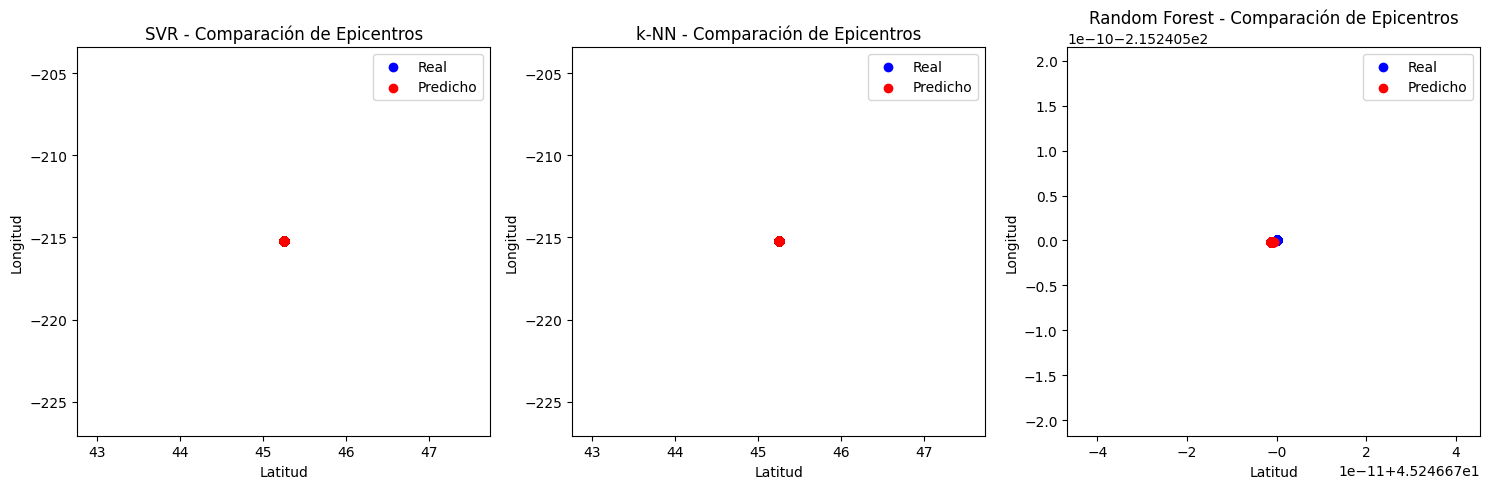

In [10]:
# Comparativa de predicciones
plt.figure(figsize=(15, 5))

for i, (name, result) in enumerate(results.items(), 1):
    plt.subplot(1, 3, i)
    plt.scatter(y_test['Epicenter Latitude'], y_test['Epicenter Longitude'], color='blue', label='Real')
    plt.scatter(result['y_pred_lat'], result['y_pred_lon'], color='red', label='Predicho')
    plt.title(f'{name} - Comparación de Epicentros')
    plt.xlabel('Latitud')
    plt.ylabel('Longitud')
    plt.legend()

plt.tight_layout()
plt.show()

In [11]:
# Validación cruzada
for name, (model_lat, model_lon) in models.items():
    scores_lat = cross_val_score(model_lat, X, y['Epicenter Latitude'], cv=10, scoring='neg_mean_squared_error')
    scores_lon = cross_val_score(model_lon, X, y['Epicenter Longitude'], cv=10, scoring='neg_mean_squared_error')
    print(f'{name} Cross-Validation MSE Latitude: {-scores_lat.mean()}')
    print(f'{name} Cross-Validation MSE Longitude: {-scores_lon.mean()}')

SVR Cross-Validation MSE Latitude: -0.0
SVR Cross-Validation MSE Longitude: -0.0
k-NN Cross-Validation MSE Latitude: -0.0
k-NN Cross-Validation MSE Longitude: 8.077935669463161e-28
Random Forest Cross-Validation MSE Latitude: 1.8843585510291885e-24
Random Forest Cross-Validation MSE Longitude: 1.3675945088401132e-25


In [12]:
# Imprimir las coordenadas del epicentro real y predicho
for name, result in results.items():
    print(f"{name}:")
    for i in range(len(y_test)):
        # Coordenadas reales
        real_lat = y_test['Epicenter Latitude'].values[i]
        real_lon = y_test['Epicenter Longitude'].values[i]

        # Coordenadas predichas
        pred_lat = result['y_pred_lat'][i]
        pred_lon = result['y_pred_lon'][i]

        # Formatear las coordenadas
        real_lat_str = f"Latitude {abs(real_lat)}° {'N' if real_lat > 0 else 'S'}"
        real_lon_str = f"Longitude {abs(real_lon)}° {'E' if real_lon > 0 else 'W'}"

        pred_lat_str = f"Latitude {abs(pred_lat)}° {'N' if pred_lat > 0 else 'S'}"
        pred_lon_str = f"Longitude {abs(pred_lon)}° {'E' if pred_lon > 0 else 'W'}"

        print(f"Real: {real_lat_str}, {real_lon_str}")
        print(f"Predicho: {pred_lat_str}, {pred_lon_str}")
        print()

Se truncaron las últimas líneas 5000 del resultado de transmisión.
Real: Latitude 45.24667° N, Longitude 215.2405° W
Predicho: Latitude 45.24667° N, Longitude 215.2405° W

Real: Latitude 45.24667° N, Longitude 215.2405° W
Predicho: Latitude 45.24667° N, Longitude 215.2405° W

Real: Latitude 45.24667° N, Longitude 215.2405° W
Predicho: Latitude 45.24667° N, Longitude 215.2405° W

Real: Latitude 45.24667° N, Longitude 215.2405° W
Predicho: Latitude 45.24667° N, Longitude 215.2405° W

Real: Latitude 45.24667° N, Longitude 215.2405° W
Predicho: Latitude 45.24667° N, Longitude 215.2405° W

Real: Latitude 45.24667° N, Longitude 215.2405° W
Predicho: Latitude 45.24667° N, Longitude 215.2405° W

Real: Latitude 45.24667° N, Longitude 215.2405° W
Predicho: Latitude 45.24667° N, Longitude 215.2405° W

Real: Latitude 45.24667° N, Longitude 215.2405° W
Predicho: Latitude 45.24667° N, Longitude 215.2405° W

Real: Latitude 45.24667° N, Longitude 215.2405° W
Predicho: Latitude 45.24667° N, Longitude 2